<div style="color: Orange; text-align: center; padding: 15px; border-radius: 5px; font-weight: bold; font-size: 32px;">Understanding the data
</div>

## Very High-level Data Structure Overview

**Observation**: 
- The data isn't in one master file. It’s fragmented geographically and temporally into separate CSVs.
- Each file represents a specific city and a specific timeframe (Weekday vs. Weekend).

**Conclusion**: The "Context" (City Name and Timeframe) is hidden in the filenames, not in the columns. This is our first challenge, we need to extract this info before we can merge anything.

## High-Level Feature Breakdown

All tables share the same schema, so we can categorize the columns based on a quick initial scan:

**Target Variable**:

- *realSum*: The total price of the listing. 
(We need to verify if this is price-per-night or price for the whole 2-day weekend).

**High-Value Features**:

- *Location*: dist (distance to center) and metro_dist (distance to metro). 
(We expect these to be the strongest price predictors.)

- *Host Type*: biz (companies) and multi (hosts with multiple listings).

(This helps us compare professional vs. individual pricing strategies.)

- *Quality*: guest_satisfaction_overall and cleanliness_rating.

## Data Integration Strategy

Since all tables have the exact same columns, we don't need complex "Joins" We just need a vertical Concatenation.

1. Country Column

2. Day_Type Column

3. Concatenation

<div style="color: Orange; text-align: center; padding: 15px; border-radius: 5px; font-weight: bold; font-size: 32px;"> Defining the Problem </div>

## 1. Define the Problem (Our "Why")
### The Core Business Problem:
The short-term rental market (Airbnb) in Europe is highly volatile. New **hosts** and property **investors** often enter the market blindly—they struggle to determine the "Fair *Market Value*" of a rental. They don't know if they should invest in a property close to the City Center (high cost) or one further out near a Metro station (lower cost), and they don't know how much premium they can charge for things like cleanliness or being a "Business" host.

### The Objective: 

To build a data-driven "Valuation & Strategy Engine that decodes the pricing logic across major European cities.

<div style="background-color: orange; color: white; text-align: center; padding: 15px; border-radius: 5px; font-weight: bold; font-size: 18px;">
We want to identify exactly which features (Location, Metro Access, Host Type) actually drive revenue, versus those that are just "nice to have."
</div>

<div style="color: White; text-align: center; padding: 15px; border-radius: 5px; font-weight: bold; font-size: 32px;"> For Who? </div>

## Target Audience (Stakeholders)

**Who are we solving this for?**

- **Property Investors** (The "Buyers"):

Pain Point: "Where should I buy my next apartment to get the **highest ROI**? Barcelona or Budapest?"

Need: *A comparative analysis* of price ceilings in different cities.

- **New Hosts** (The "Sellers"):

Pain Point: "I have an apartment 3km from the center. **How much should I charge** on Weekends vs. Weekdays?"

Need: *A pricing benchmark* based on their specific features (Private room vs. Entire home).

## Check List Of Question To Answer

- Does being close to a Metro station (metro_dist) compensate for being far from the City Center (dist) in terms of pricing power?

- Do professional agencies (biz=1) successfully charge significantly higher rates than individual hosts for similar properties?

- Which cities are "Weekend Economies" (massive price spikes) vs. "Stable Economies" (consistent pricing)?

<div style="color: Orange; text-align: center; padding: 15px; border-radius: 5px; font-weight: bold; font-size: 32px;"> Basic Data Cleaning </div>

## Load and Quick Inspection

In [1]:
import pandas as pd
import numpy as np

In [2]:
merged_data_path = '/kaggle/input/v2-airbnb/Airbnb (1).csv'

In [3]:
df= pd.read_csv(merged_data_path)
df.head()

,ID,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,City,Country,Day_Type,Room Status
0,0,194.03,Private room,2,Regular Host,Multi Room,Regular List,10,93,1,...,78.690,4.167,98.254,6.846,4.90569,52.41772,amsterdam,Netherlands,weekday,Private Room
1,1,344.25,Private room,4,Regular Host,Single Room,Regular List,8,85,1,...,631.176,33.421,837.281,58.343,4.90005,52.37432,amsterdam,Netherlands,weekday,Private Room
2,2,264.10,Private room,2,Regular Host,Single Room,Business List,9,87,1,...,75.276,3.986,95.387,6.647,4.97512,52.36103,amsterdam,Netherlands,weekday,Private Room
3,3,433.53,Private room,4,Regular Host,Single Room,Business List,9,90,2,...,493.273,26.119,875.033,60.974,4.89417,52.37663,amsterdam,Netherlands,weekday,Private Room
4,4,485.55,Private room,2,Super Host,Single Room,Regular List,10,98,1,...,552.830,29.273,815.306,56.812,4.90051,52.37508,amsterdam,Netherlands,weekday,Private Room


In [4]:
print(f"Total Shape: {df.shape}")
print("-" * 30)

print("Missing Values:\n", df.isnull().sum())
print("-" * 30)

print(f"Duplicate Rows: {df.duplicated().sum()}")

Total Shape: (51707, 22)
------------------------------
Missing Values:
 ID                            0
realSum                       0
room_type                     0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
city centre Distance          0
metro Distance                0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
City                          0
Country                       0
Day_Type                      0
Room Status                   0
dtype: int64
------------------------------
Duplicate Rows: 0


In [5]:
# Check Are numbers stored as text?
print("Data Types:\n", df.dtypes)
print("-" * 30)

Data Types:
 ID                              int64
realSum                       float64
room_type                      object
person_capacity                 int64
host_is_superhost              object
multi                          object
biz                            object
cleanliness_rating              int64
guest_satisfaction_overall      int64
bedrooms                        int64
city centre Distance          float64
metro Distance                float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
City                           object
Country                        object
Day_Type                       object
Room Status                    object
dtype: object
------------------------------


🚩 realSum (The Price)—is stored as an object (text), not a number.

In [6]:
# Remove '$' and ',' then convert
df['realSum'] = df['realSum'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['realSum'] = pd.to_numeric(df['realSum'])

In [7]:
df['Day_Type']

0        weekday
1        weekday
2        weekday
3        weekday
4        weekday
          ...   
51702    weekend
51703    weekend
51704    weekend
51705    weekend
51706    weekend
Name: Day_Type, Length: 51707, dtype: object

In [8]:
mean_weekday = df[df['Day_Type'] == 'weekday']['realSum'].mean()
mean_weekend = df[df['Day_Type'] == 'weekend']['realSum'].mean()

print(f"Average Weekday Price: {mean_weekday:.2f}")
print(f"Average Weekend Price: {mean_weekend:.2f}")

ratio = mean_weekend / mean_weekday
print(f"Ratio (Weekend / Weekday): {ratio:.2f}")

Average Weekday Price: 275.68
Average Weekend Price: 283.96
Ratio (Weekend / Weekday): 1.03


<div style="color: Orange; text-align: center; padding: 15px; border-radius: 5px; font-weight: bold; font-size: 32px;"> Exploratory Analysis </div>

### Global Style Set

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
BLACK  = "black"
ORANGE = "orange"
GREY = "grey"

In [11]:
sns.set_theme(style="darkgrid", rc={
    "axes.facecolor": BLACK,      # Background of the plot
    "figure.facecolor": BLACK,    # Background of the entire figure
    "axes.edgecolor": ORANGE,     # Border color
    "grid.color": GREY,           # Grid line color
    "text.color": "white",        # Text color
    "xtick.color": "white",       # X-axis tick color
    "ytick.color": "white",       # Y-axis tick color
    "axes.labelcolor": "white",   # Axis labels
    "axes.titlesize": 16
})

In [12]:
custom_palette = sns.blend_palette([ORANGE, "white"], n_colors=6)
sns.set_palette(custom_palette)

### Exploration

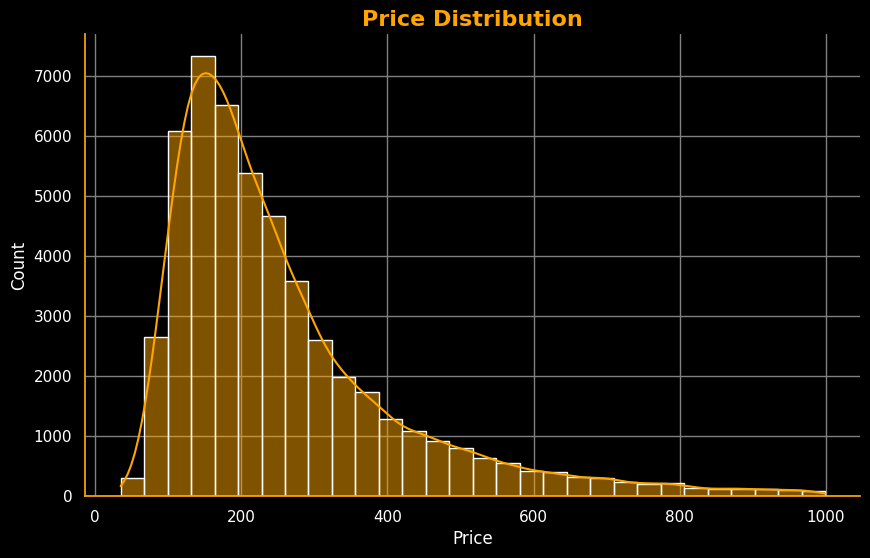

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['realSum'] < 1000]['realSum'], kde=True, color=ORANGE, bins=30)

plt.title('Price Distribution', color=ORANGE, fontweight='bold')
plt.xlabel('Price', color='white')
plt.ylabel('Count', color='white')

sns.despine()
plt.show()

In [14]:
print(df['realSum'].mean())
print(df['realSum'].mode())

279.8796561394009
0    184.46
Name: realSum, dtype: float64


As a Host/ Investor **Do not trust the "Average" price. The average is inflated by the expensive luxury apartments.**

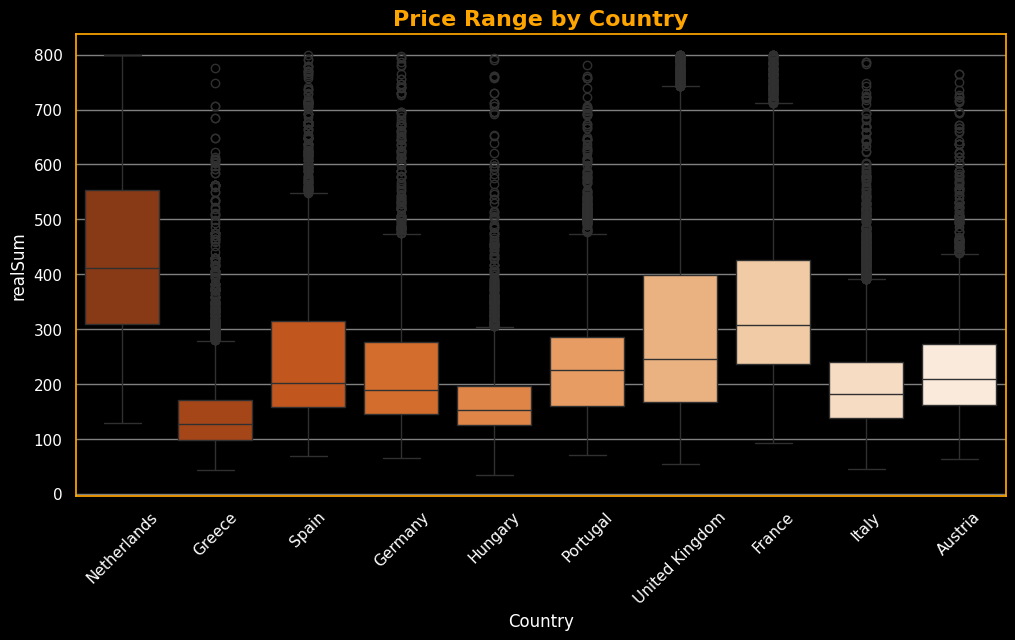

In [15]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='realSum', data=df[df['realSum'] < 800], palette="Oranges_r")

plt.title('Price Range by Country', color=ORANGE, fontweight='bold')
plt.xticks(rotation=45, color='white')
plt.show()

The "Most Expensive" Market is **Netherlands** with median price about 400.

There are a High Variance Markets (Netherlands, France, UK)

-> As a Guest you can find a room for 100 or 600. The pricing is not standardized; it depends heavily on the specific property features.

In [16]:
df['City'].value_counts()

City
london       9993
rome         9027
paris        6688
lisbon       5763
athens       5280
budapest     4022
vienna       3537
barcelona    2833
berlin       2484
amsterdam    2080
Name: count, dtype: int64

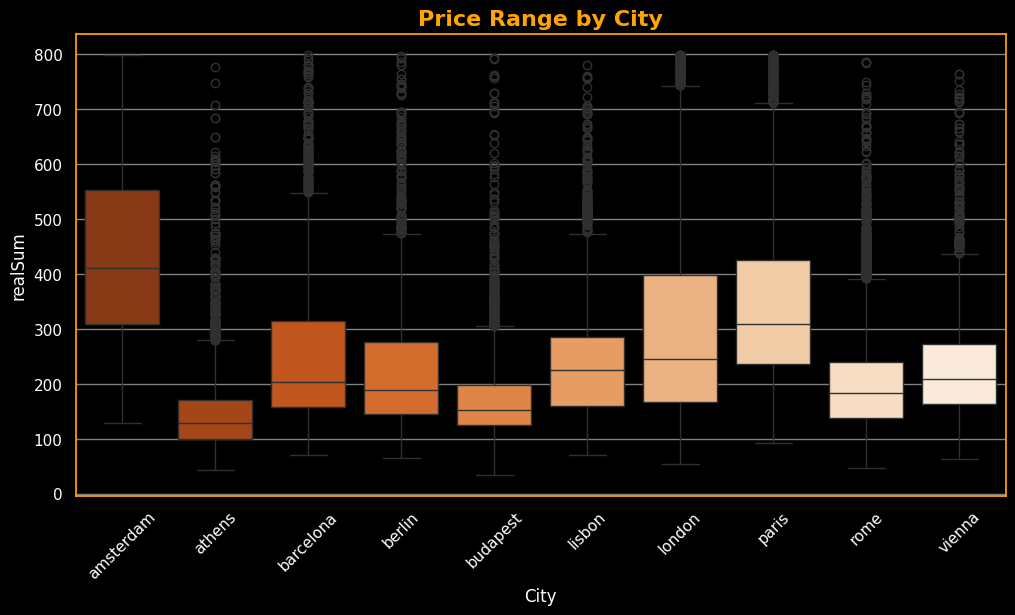

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='City', y='realSum', data=df[df['realSum'] < 800], palette="Oranges_r")

plt.title('Price Range by City', color=ORANGE, fontweight='bold')
plt.xticks(rotation=45, color='white')
plt.show()

In [18]:
print(f"Number of unique cities: {df['City'].nunique()}")
print("-" * 20)
print(df['City'].unique())

Number of unique cities: 10
--------------------
['amsterdam' 'athens' 'barcelona' 'berlin' 'budapest' 'lisbon' 'london'
 'paris' 'rome' 'vienna']


In [19]:
from matplotlib.colors import LinearSegmentedColormap

corr_matrix = df.corr(numeric_only=True)
cmap_orange = LinearSegmentedColormap.from_list("BlackOrange", ['white', ORANGE, BLACK])

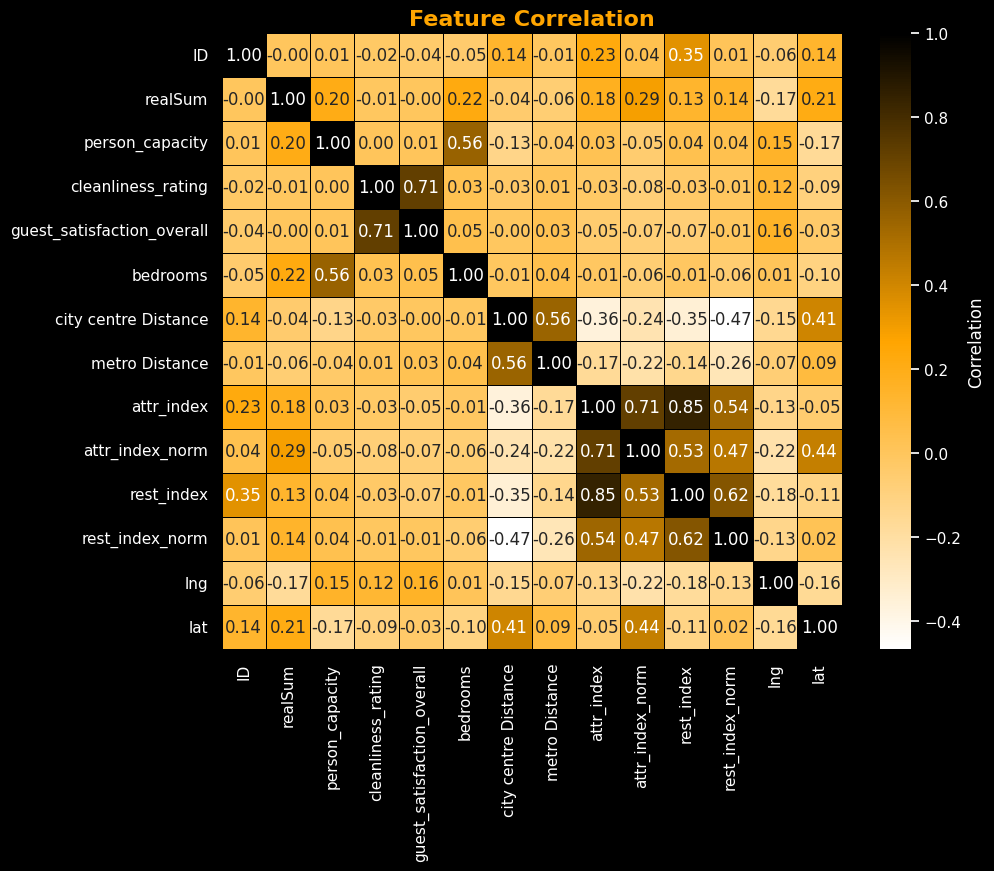

In [20]:
plt.figure(figsize=(10, 8))

from matplotlib.colors import LinearSegmentedColormap
cmap_orange = LinearSegmentedColormap.from_list("BlackOrange", ['white', ORANGE, BLACK])

sns.heatmap(corr_matrix, annot=True, cmap=cmap_orange, fmt=".2f", 
            linewidths=0.5, linecolor=BLACK, cbar_kws={'label': 'Correlation'})

plt.title('Feature Correlation', color=ORANGE, fontweight='bold')
plt.show()

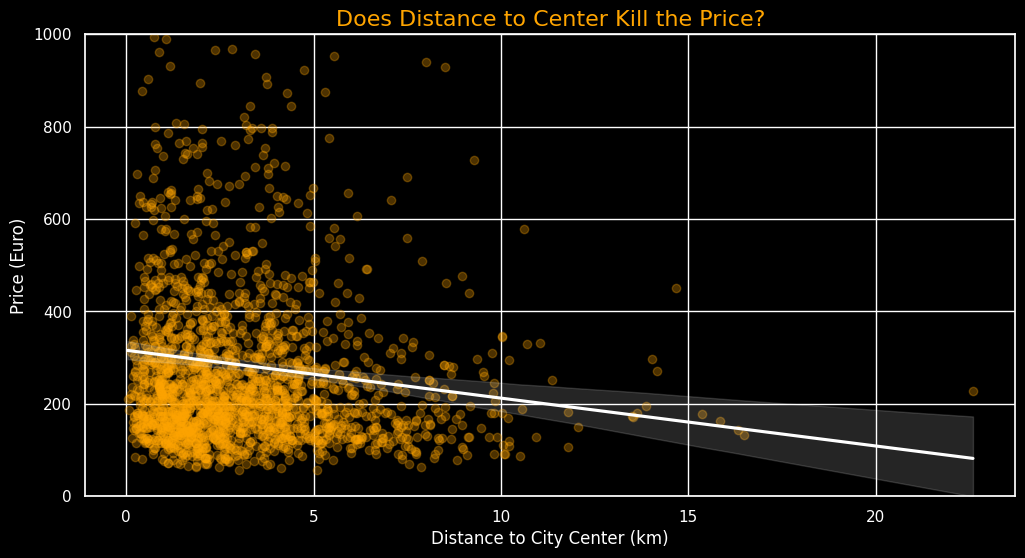

In [21]:
sns.set_theme(style="darkgrid", rc={"axes.facecolor": BLACK, "figure.facecolor": BLACK, "text.color": "white", "axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"})

plt.figure(figsize=(12, 6))

sns.regplot(x='city centre Distance', y='realSum', data=df.sample(2000), 
            scatter_kws={'alpha':0.3, 'color': ORANGE}, 
            line_kws={'color': 'white'})

plt.title('Does Distance to Center Kill the Price?', color=ORANGE, fontsize=16)
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Price (Euro)')
plt.ylim(0, 1000)
plt.show()

In [22]:
print(df['biz'].value_counts())

biz
Regular List     33599
Business List    18108
Name: count, dtype: int64


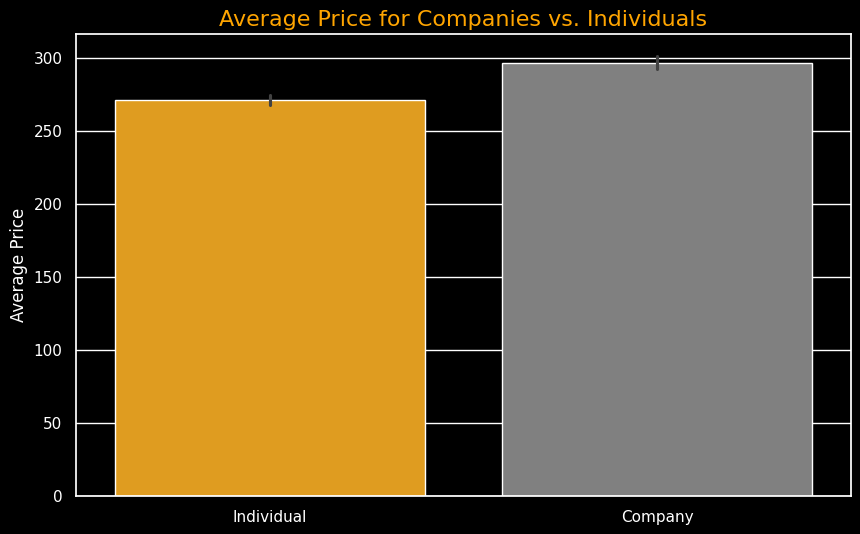

In [23]:
plt.figure(figsize=(10, 6))

df['Host_Type'] = df['biz'].apply(lambda x: 'Company' if x == 'Business List' else 'Individual')

sns.barplot(x='Host_Type', y='realSum', data=df, palette=[ORANGE, 'grey'])

plt.title('Average Price for Companies vs. Individuals', color=ORANGE, fontsize=16)
plt.ylabel('Average Price')
plt.xlabel('')
plt.show()

In [24]:
print(df['Host_Type'].value_counts())

Host_Type
Individual    33599
Company       18108
Name: count, dtype: int64


In [25]:
print("rel between multi feature and n of rooms:")
print(df.groupby(['multi', 'bedrooms']).size().head(10))

rel between multi feature and n of rooms:
multi         bedrooms
Multi Room    0            1029
              1           11105
              2            2511
              3             385
              4              26
              5               5
              8               2
              10              2
Single Room   0            3456
              1           25228
dtype: int64


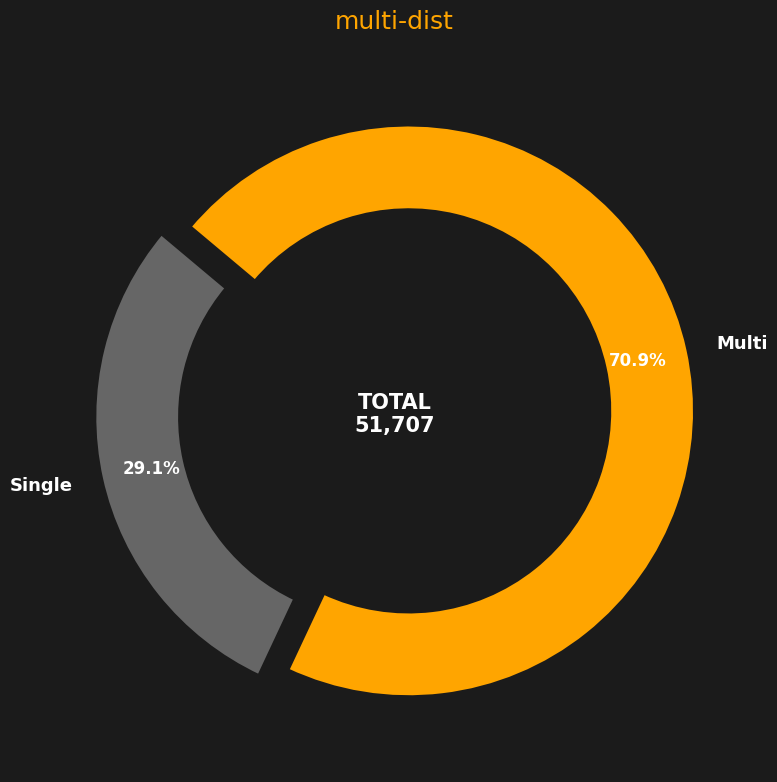

In [26]:
import matplotlib.pyplot as plt


multi_counts = df['multi'].value_counts().sort_index()
labels = ['Single', 'Multi']


plt.figure(figsize=(8, 8))
plt.gcf().set_facecolor('#1B1B1B') # Dark theme background
wedges, texts, autotexts = plt.pie(
    multi_counts, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['#666666', ORANGE], # Grey for Single, Orange for Multi
    pctdistance=0.82,          # Position of the percentage labels
    explode=[0.05, 0.05],      # Adds a small gap between slices
    textprops={'color': 'white', 'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'width': 0.3, 'edgecolor': '#1B1B1B', 'linewidth': 3} # width=0.3 creates the "Donut"
)

for text in texts:
    text.set_color('white')
    text.set_fontsize(13)
    text.set_weight('bold')

total_listings = multi_counts.sum()
plt.text(0, 0, f'TOTAL\n{total_listings:,}', ha='center', va='center', 
         color='white', fontsize=15, fontweight='bold')

plt.title('multi-dist', color=ORANGE, fontsize=18, pad=20)

plt.tight_layout()
plt.show()

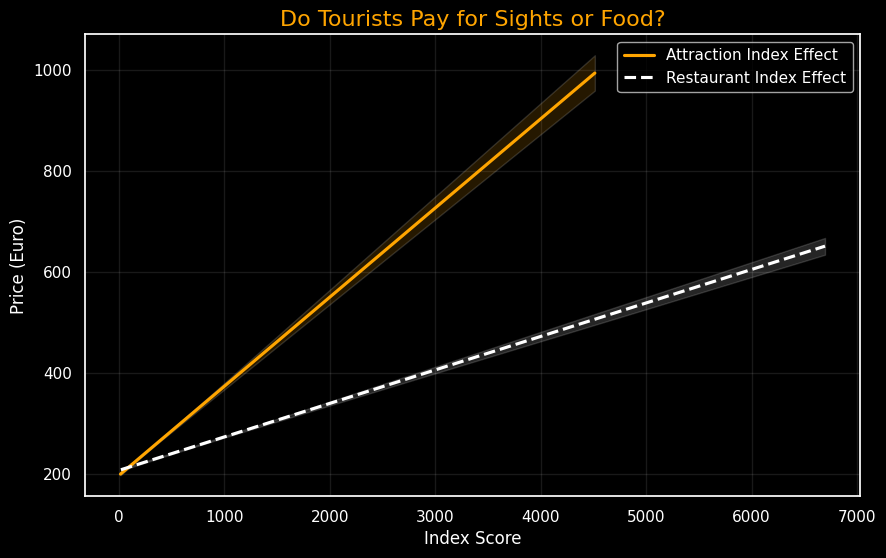

In [27]:
plt.figure(figsize=(10, 6))


subset = df[df['realSum'] < 800]


sns.regplot(x='attr_index', y='realSum', data=subset, 
            scatter=False, label='Attraction Index Effect', color=ORANGE)

sns.regplot(x='rest_index', y='realSum', data=subset, 
            scatter=False, label='Restaurant Index Effect', color='white', line_kws={'linestyle':'--'})

plt.title('Do Tourists Pay for Sights or Food?', color=ORANGE, fontsize=16)
plt.xlabel('Index Score', color='white')
plt.ylabel('Price (Euro)', color='white')
plt.legend(facecolor='black', labelcolor='white')
plt.grid(True, alpha=0.1)
plt.show()

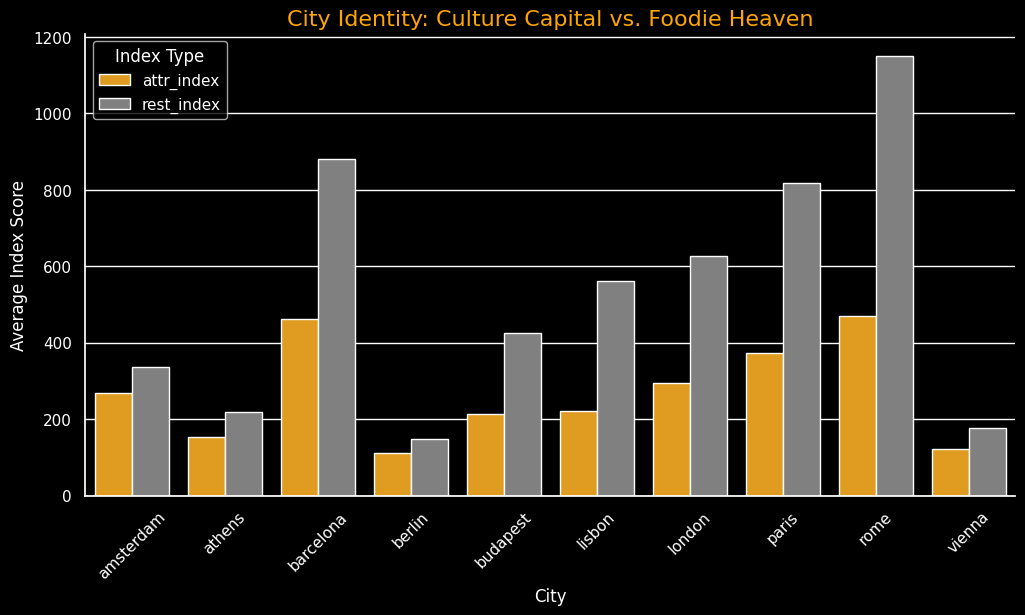

In [28]:
plt.figure(figsize=(12, 6))

# 1. Group by the correct column name 'City'
city_indices = df.groupby('City')[['attr_index', 'rest_index']].mean().reset_index()

# 2. Melt using 'City'
city_indices_melted = city_indices.melt(id_vars='City', var_name='Index_Type', value_name='Score')

# 3. Plot using 'City' (Capitalized)
sns.barplot(
    x='City', # Changed from 'city' to 'City'
    y='Score', 
    hue='Index_Type', 
    data=city_indices_melted, 
    palette=[ORANGE, 'grey']
)

plt.title('City Identity: Culture Capital vs. Foodie Heaven', color=ORANGE, fontsize=16)
plt.ylabel('Average Index Score', color='white')
plt.xlabel('City', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')

# Legend styling
legend = plt.legend(title='Index Type', facecolor='black', labelcolor='white')
plt.setp(legend.get_title(), color='white')

sns.despine()
plt.show()

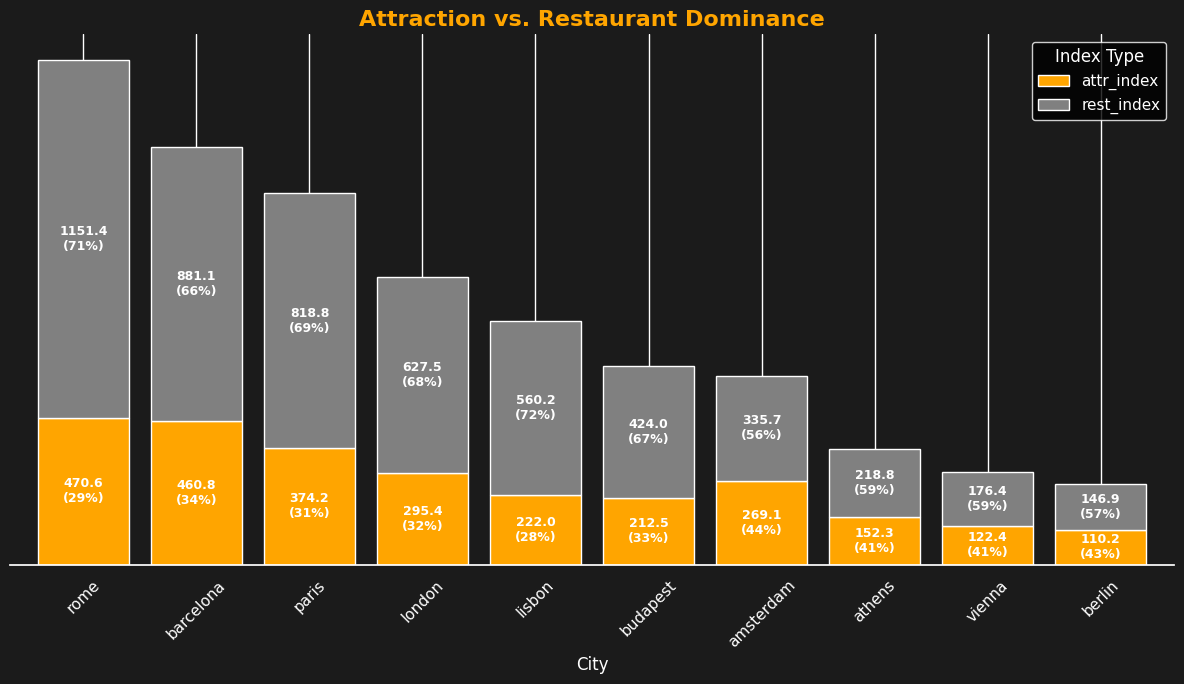

In [29]:
# 1. Prepare the Data: Group and calculate means
city_indices = df.groupby('City')[['attr_index', 'rest_index']].mean()

# Calculate Total and Percentages for labels
city_indices['Total'] = city_indices.sum(axis=1)
city_indices_sorted = city_indices.sort_values('Total', ascending=False).drop(columns='Total')

# 2. Plotting
fig, ax = plt.subplots(figsize=(12, 7))

# Create the stacked bars
# We use the sorted dataframe directly
city_indices_sorted.plot(kind='bar', stacked=True, color=[ORANGE, 'grey'], ax=ax, width=0.8)

# 3. Add Labels and Percentages INSIDE the segments
for i, container in enumerate(ax.containers):
    # Calculate percentages for each bar segment
    # i=0 is attr_index, i=1 is rest_index
    labels = []
    for j, rect in enumerate(container):
        height = rect.get_height()
        total = city_indices_sorted.iloc[j].sum()
        percentage = (height / total) * 100
        # Only show label if the segment is large enough to fit text
        labels.append(f'{height:.1f}\n({percentage:.0f}%)')
    
    # Add the labels to the center of each segment
    ax.bar_label(container, labels=labels, label_type='center', 
                 color='white', fontweight='bold', fontsize=9)

# 4. Global Styling (Dark Theme)
plt.title('Attraction vs. Restaurant Dominance', color=ORANGE, fontsize=16, fontweight='bold')
plt.ylabel('Combined Index Score', color='white')
plt.xlabel('City', color='white')
plt.xticks(rotation=45, color='white')

# Remove Y-axis as labels are inside
ax.yaxis.set_visible(False)
sns.despine(left=True)

# Legend Styling
legend = plt.legend(title='Index Type', facecolor='black', edgecolor='white', loc='upper right')
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color("white")

# Background color
ax.set_facecolor('#1B1B1B')
fig.patch.set_facecolor('#1B1B1B')

plt.tight_layout()
plt.show()

## Internal Feature Engineering

#### Price for each person

In [30]:
df['realSum'] = df['realSum'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

In [31]:
df['Price_per_person'] = df['realSum'] / df['person_capacity']

#### Price per bedroom

In [32]:
df['Price_per_bedroom'] = df['realSum'] / np.where(df['bedrooms'] == 0, 1, df['bedrooms'])

#### distance rate

In [33]:
# < 0.5km = Prime, 0.5-2.0km = Walkable, > 2.0km = Remote

conditions = [
    (df['metro Distance'] <= 0.5),
    (df['metro Distance'] > 0.5) & (df['metro Distance'] <= 2.0),
    (df['metro Distance'] > 2.0)
]
choices = ['Prime Location', 'Walkable', 'Remote']

df['Distance_Score'] = np.select(conditions, choices, default='Remote')

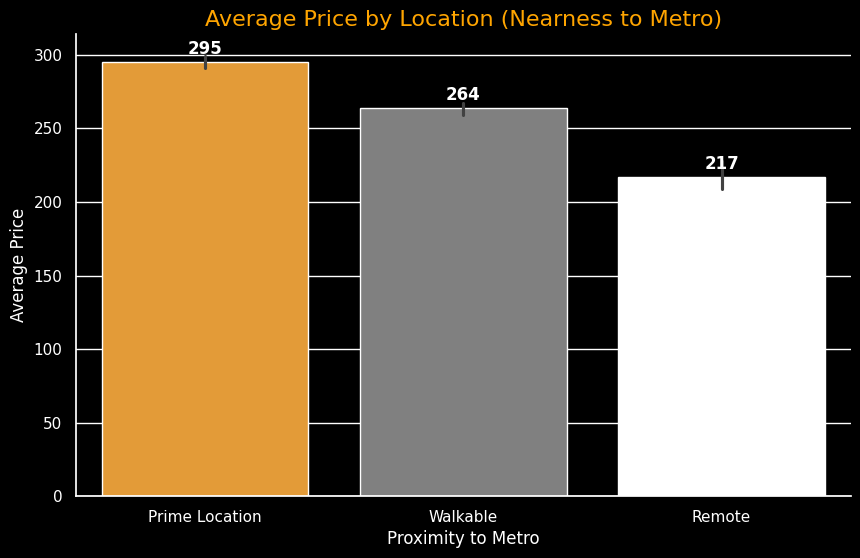

In [34]:
plt.figure(figsize=(10, 6))

order = ['Prime Location', 'Walkable', 'Remote']

ax = sns.barplot(
    x='Distance_Score', 
    y='realSum', 
    data=df, 
    order=order, 
    palette=['#FF9F1C', 'grey', 'white'],
)

for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', color='white', padding=3, fontweight='bold')

plt.title('Average Price by Location (Nearness to Metro)', color=ORANGE, fontsize=16)
plt.ylabel('Average Price', color='white')
plt.xlabel('Proximity to Metro', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
sns.despine() # 

plt.show()

<Figure size 1200x600 with 0 Axes>

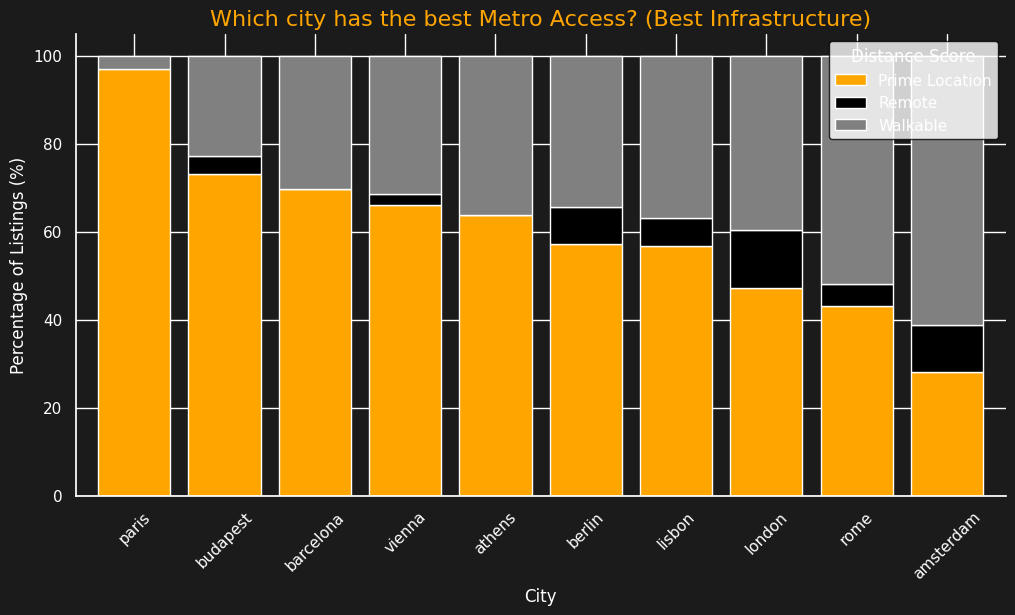

In [35]:
plt.figure(figsize=(12, 6))

metro_mix = pd.crosstab(df['City'], df['Distance_Score'])
metro_mix = metro_mix.div(metro_mix.sum(1), axis=0) * 100
metro_mix = metro_mix.sort_values('Prime Location', ascending=False)

ax = metro_mix.plot(kind='bar', stacked=True, color=[ORANGE, 'black', 'grey'], figsize=(12,6), width=0.8)

plt.title('Which city has the best Metro Access? (Best Infrastructure)', color=ORANGE, fontsize=16)
plt.ylabel('Percentage of Listings (%)', color='white')
plt.xlabel('City', color='white')
plt.legend(title='Distance Score', frameon=True, facecolor='white', edgecolor='black')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')

ax.set_facecolor('#1B1B1B')
plt.gcf().set_facecolor('#1B1B1B')
sns.despine()

plt.show()

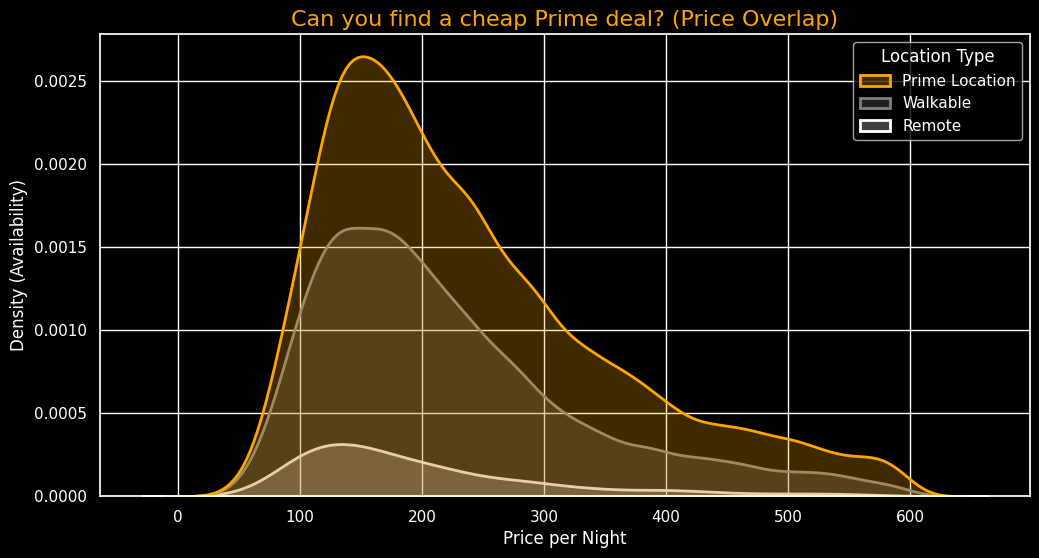

In [36]:
plt.figure(figsize=(12, 6))

sns.kdeplot(
    data=df[df['realSum'] < 600],  
    x='realSum',                  
    hue='Distance_Score',       
    hue_order=['Prime Location', 'Walkable', 'Remote'], 
    palette=[ORANGE, 'grey', 'white'],
    fill=True,                   
    linewidth=2
)

plt.title('Can you find a cheap Prime deal? (Price Overlap)', color=ORANGE, fontsize=16)
plt.xlabel('Price per Night', color='white')
plt.ylabel('Density (Availability)', color='white')
plt.xticks(color='white')
plt.yticks(color='white')


legend = plt.gca().get_legend()
if legend:
    for text in legend.get_texts():
        text.set_color("white")
    legend.set_title("Location Type")
    legend.get_title().set_color("white")

plt.show()

In [37]:
df['Quality_Ratio'] = df['guest_satisfaction_overall'] / (df['cleanliness_rating'] * 10)

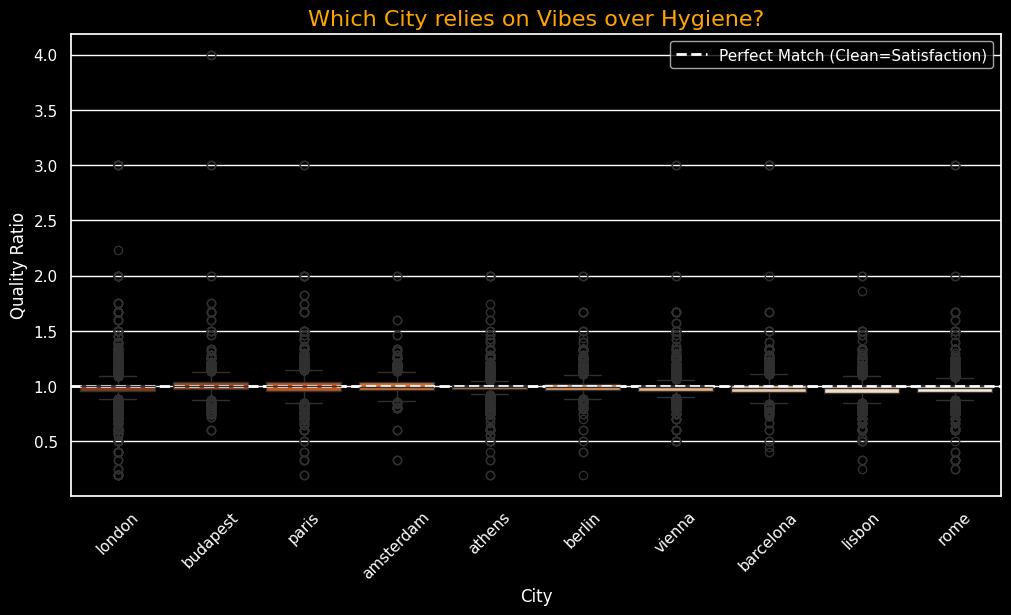

In [38]:
plt.figure(figsize=(12, 6))

rank = df.groupby('City')['Quality_Ratio'].median().sort_values(ascending=False).index

sns.boxplot(x='City', y='Quality_Ratio', data=df, order=rank, palette='Oranges_r')

plt.axhline(1.0, color='white', linestyle='--', linewidth=2, label='Perfect Match (Clean=Satisfaction)')

plt.title('Which City relies on Vibes over Hygiene?', color=ORANGE, fontsize=16)
plt.ylabel('Quality Ratio', color='white')
plt.xlabel('City', color='white')
plt.xticks(rotation=45, color='white')
plt.legend(facecolor='black', labelcolor='white')
plt.show()

In [39]:
df

,ID,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,lat,City,Country,Day_Type,Room Status,Host_Type,Price_per_person,Price_per_bedroom,Distance_Score,Quality_Ratio
0,0,194.03,Private room,2,Regular Host,Multi Room,Regular List,10,93,1,...,52.41772,amsterdam,Netherlands,weekday,Private Room,Individual,97.015000,194.030000,Remote,0.930000
1,1,344.25,Private room,4,Regular Host,Single Room,Regular List,8,85,1,...,52.37432,amsterdam,Netherlands,weekday,Private Room,Individual,86.062500,344.250000,Prime Location,1.062500
2,2,264.10,Private room,2,Regular Host,Single Room,Business List,9,87,1,...,52.36103,amsterdam,Netherlands,weekday,Private Room,Company,132.050000,264.100000,Remote,0.966667
3,3,433.53,Private room,4,Regular Host,Single Room,Business List,9,90,2,...,52.37663,amsterdam,Netherlands,weekday,Private Room,Company,108.382500,216.765000,Prime Location,1.000000
4,4,485.55,Private room,2,Super Host,Single Room,Regular List,10,98,1,...,52.37508,amsterdam,Netherlands,weekday,Private Room,Individual,242.775000,485.550000,Prime Location,0.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,51702,715.94,Entire home/apt,6,Regular Host,Single Room,Business List,10,100,3,...,48.21136,vienna,Austria,weekend,Entrie home/apt,Company,119.323333,238.646667,Prime Location,1.000000
51703,51703,304.79,Entire home/apt,2,Regular Host,Single Room,Regular List,8,86,1,...,48.20296,vienna,Austria,weekend,Entrie home/apt,Individual,152.395000,304.790000,Prime Location,1.075000
51704,51704,637.17,Entire home/apt,2,Regular Host,Single Room,Regular List,10,93,1,...,48.20460,vienna,Austria,weekend,Entrie home/apt,Individual,318.585000,637.170000,Prime Location,0.930000
51705,51705,301.05,Private room,2,Regular Host,Single Room,Regular List,10,87,1,...,48.19200,vienna,Austria,weekend,Private Room,Individual,150.525000,301.050000,Prime Location,0.870000


### Value for Money Score
`guest_satisfaction_overall ÷ realSum`

In [40]:
df['Value_Score'] = (df['guest_satisfaction_overall'] * 100) / (df['realSum'] + 1)
#adding 1 to avoid dividing by 0

#### Price Divergence
as the price only not the perfect indecator (to detect if the unit is Overpriced to another base , the avg)

In [41]:
avg_price_by_type = df.groupby('room_type')['realSum'].transform('mean')

In [42]:
df['Price_Divergence_Pct'] = (df['realSum'] - avg_price_by_type) / avg_price_by_type

### Price city z-score

In [43]:
city_avg_price = df.groupby('City')['realSum'].transform('mean')
city_std_price = df.groupby('City')['realSum'].transform('std')

df['Price_City_Zscore'] = (df['realSum'] - city_avg_price) / city_std_price

In [44]:
df

,ID,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,Day_Type,Room Status,Host_Type,Price_per_person,Price_per_bedroom,Distance_Score,Quality_Ratio,Value_Score,Price_Divergence_Pct,Price_City_Zscore
0,0,194.03,Private room,2,Regular Host,Multi Room,Regular List,10,93,1,...,weekday,Private Room,Individual,97.015000,194.030000,Remote,0.930000,47.684972,-0.053236,-0.880240
1,1,344.25,Private room,4,Regular Host,Single Room,Regular List,8,85,1,...,weekday,Private Room,Individual,86.062500,344.250000,Prime Location,1.062500,24.619841,0.679758,-0.531425
2,2,264.10,Private room,2,Regular Host,Single Room,Business List,9,87,1,...,weekday,Private Room,Company,132.050000,264.100000,Remote,0.966667,32.817805,0.288668,-0.717536
3,3,433.53,Private room,4,Regular Host,Single Room,Business List,9,90,2,...,weekday,Private Room,Company,108.382500,216.765000,Prime Location,1.000000,20.712034,1.115397,-0.324115
4,4,485.55,Private room,2,Super Host,Single Room,Regular List,10,98,1,...,weekday,Private Room,Individual,242.775000,485.550000,Prime Location,0.980000,20.141815,1.369227,-0.203323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,51702,715.94,Entire home/apt,6,Regular Host,Single Room,Business List,10,100,3,...,weekend,Entrie home/apt,Company,119.323333,238.646667,Prime Location,1.000000,13.948169,1.207543,1.192611
51703,51703,304.79,Entire home/apt,2,Regular Host,Single Room,Regular List,8,86,1,...,weekend,Entrie home/apt,Individual,152.395000,304.790000,Prime Location,1.075000,28.123876,-0.060205,0.158914
51704,51704,637.17,Entire home/apt,2,Regular Host,Single Room,Regular List,10,93,1,...,weekend,Entrie home/apt,Individual,318.585000,637.170000,Prime Location,0.930000,14.572919,0.964662,0.994571
51705,51705,301.05,Private room,2,Regular Host,Single Room,Regular List,10,87,1,...,weekend,Private Room,Individual,150.525000,301.050000,Prime Location,0.870000,28.803178,0.468965,0.149511


In [45]:
df.columns

Index(['ID', 'realSum', 'room_type', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'city centre Distance', 'metro Distance', 'attr_index',
       'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat',
       'City', 'Country', 'Day_Type', 'Room Status', 'Host_Type',
       'Price_per_person', 'Price_per_bedroom', 'Distance_Score',
       'Quality_Ratio', 'Value_Score', 'Price_Divergence_Pct',
       'Price_City_Zscore'],
      dtype='object')

In [46]:
df['city centre Distance'].head()

0    5.023
1    0.488
2    5.748
3    0.385
4    0.545
Name: city centre Distance, dtype: float64

### Price Relative To City

In [47]:
df['Price_City_Zscore'] = (df['realSum'] - city_avg_price) / city_std_price
# 0->nice, 2 over priced for its city, -1 -> cheap

### Adding wether data

In [48]:
summer_temps = {
    'Athens': 29,    'Lisbon': 24,    'Barcelona': 24,  'Rome': 26,
    'Budapest': 22,  'Vienna': 21,    'Paris': 20,
    'London': 19,    'Berlin': 19,    'Amsterdam': 17
}

winter_temps = {
    'Athens': 10,    'Lisbon': 12,    'Barcelona': 10,  'Rome': 8,
    'Budapest': 0,   'Vienna': 1,     'Paris': 5,
    'London': 5,     'Berlin': 1,     'Amsterdam': 3
}

In [49]:
df['summer_temp'] = df['City'].str.title().map(summer_temps)
df['winter_temp'] = df['City'].str.title().map(winter_temps)

df['temp_variance'] = df['summer_temp'] - df['winter_temp']

In [50]:
df

,ID,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,Price_per_person,Price_per_bedroom,Distance_Score,Quality_Ratio,Value_Score,Price_Divergence_Pct,Price_City_Zscore,summer_temp,winter_temp,temp_variance
0,0,194.03,Private room,2,Regular Host,Multi Room,Regular List,10,93,1,...,97.015000,194.030000,Remote,0.930000,47.684972,-0.053236,-0.880240,17,3,14
1,1,344.25,Private room,4,Regular Host,Single Room,Regular List,8,85,1,...,86.062500,344.250000,Prime Location,1.062500,24.619841,0.679758,-0.531425,17,3,14
2,2,264.10,Private room,2,Regular Host,Single Room,Business List,9,87,1,...,132.050000,264.100000,Remote,0.966667,32.817805,0.288668,-0.717536,17,3,14
3,3,433.53,Private room,4,Regular Host,Single Room,Business List,9,90,2,...,108.382500,216.765000,Prime Location,1.000000,20.712034,1.115397,-0.324115,17,3,14
4,4,485.55,Private room,2,Super Host,Single Room,Regular List,10,98,1,...,242.775000,485.550000,Prime Location,0.980000,20.141815,1.369227,-0.203323,17,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,51702,715.94,Entire home/apt,6,Regular Host,Single Room,Business List,10,100,3,...,119.323333,238.646667,Prime Location,1.000000,13.948169,1.207543,1.192611,21,1,20
51703,51703,304.79,Entire home/apt,2,Regular Host,Single Room,Regular List,8,86,1,...,152.395000,304.790000,Prime Location,1.075000,28.123876,-0.060205,0.158914,21,1,20
51704,51704,637.17,Entire home/apt,2,Regular Host,Single Room,Regular List,10,93,1,...,318.585000,637.170000,Prime Location,0.930000,14.572919,0.964662,0.994571,21,1,20
51705,51705,301.05,Private room,2,Regular Host,Single Room,Regular List,10,87,1,...,150.525000,301.050000,Prime Location,0.870000,28.803178,0.468965,0.149511,21,1,20


### Data Enhancement

In [51]:
pip install scikit-learn BallTree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [52]:
coords = np.radians(df[['lat', 'lng']].values)

In [53]:
from sklearn.neighbors import BallTree

tree = BallTree(coords, metric='haversine')

In [54]:
# نصف قطر الأرض = 6371 كم، وانا هعتبر بس 500 متر (0.5 كم)
radius = 0.5 / 6371

# عدد الجيران في دايرة 500 متر
df['Density_500m'] = tree.query_radius(coords, r=radius, count_only=True)

# طرحت 1 عشان الرقم شامل الشقة نفسها
df['Density_500m'] = df['Density_500m'] - 1

In [55]:
df.head(3)

,ID,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,Price_per_bedroom,Distance_Score,Quality_Ratio,Value_Score,Price_Divergence_Pct,Price_City_Zscore,summer_temp,winter_temp,temp_variance,Density_500m
0,0,194.03,Private room,2,Regular Host,Multi Room,Regular List,10,93,1,...,194.03,Remote,0.930000,47.684972,-0.053236,-0.880240,17,3,14,2
1,1,344.25,Private room,4,Regular Host,Single Room,Regular List,8,85,1,...,344.25,Prime Location,1.062500,24.619841,0.679758,-0.531425,17,3,14,110
2,2,264.10,Private room,2,Regular Host,Single Room,Business List,9,87,1,...,264.10,Remote,0.966667,32.817805,0.288668,-0.717536,17,3,14,7


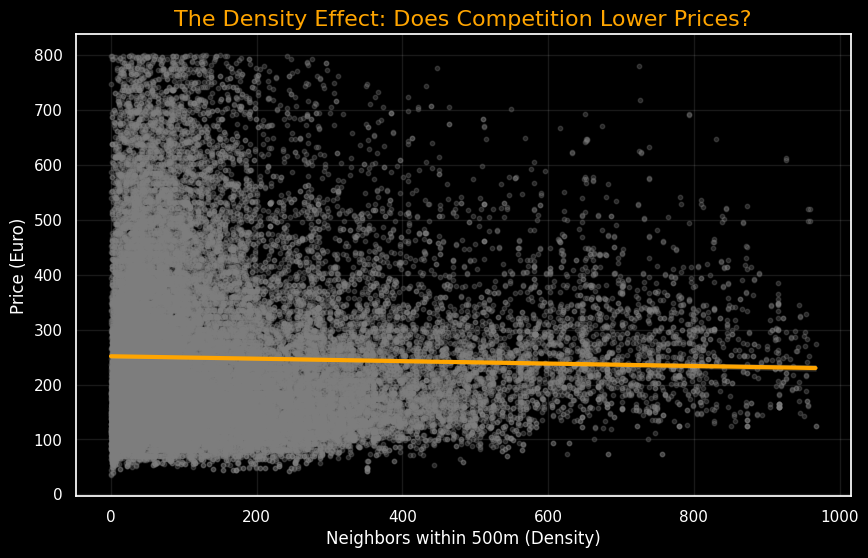

In [56]:
plt.figure(figsize=(10, 6))
subset = df[df['realSum'] < 800]

sns.regplot(
    x='Density_500m', 
    y='realSum', 
    data=subset, 
    scatter_kws={'alpha': 0.3, 'color': 'grey', 's': 10}, # نقط رمادي باهتة
    line_kws={'color': ORANGE, 'linewidth': 3}            # خط الاتجاه برتقالي
)

plt.title('The Density Effect: Does Competition Lower Prices?', color=ORANGE, fontsize=16)
plt.xlabel('Neighbors within 500m (Density)', color='white')
plt.ylabel('Price (Euro)', color='white')
plt.grid(True, alpha=0.1)
plt.show()

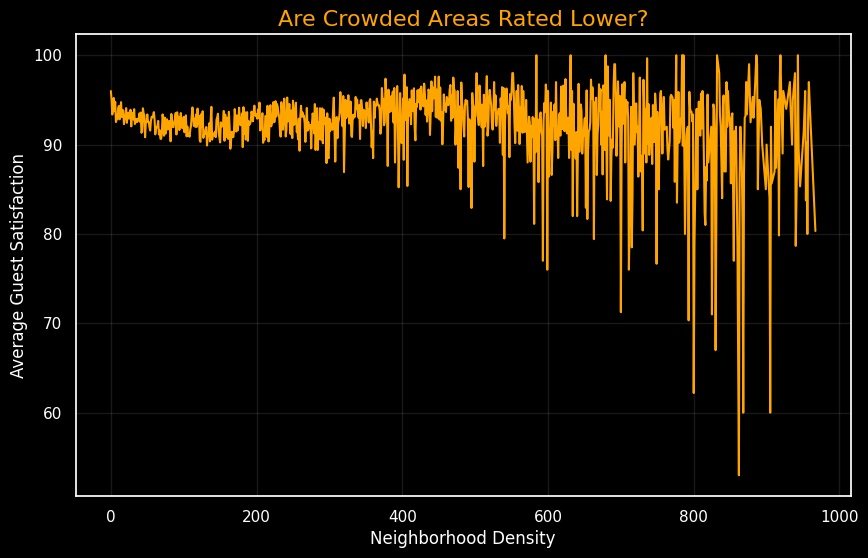

In [57]:
plt.figure(figsize=(10, 6))

df['Density_Bin'] = pd.cut(df['Density_500m'], bins=10)

sns.lineplot(
    x='Density_500m', 
    y='guest_satisfaction_overall', 
    data=df, 
    color=ORANGE,
    errorbar=None 
)

plt.title('Are Crowded Areas Rated Lower?', color=ORANGE, fontsize=16)
plt.xlabel('Neighborhood Density', color='white')
plt.ylabel('Average Guest Satisfaction', color='white')
plt.grid(True, alpha=0.1)
plt.show()

In [58]:
def categorize_density(n):
    if n < 10: return 'Rural/Quiet'
    elif n < 50: return 'Suburban'
    else: return 'Urban/Hotspot'

df['Location_Type'] = df['Density_500m'].apply(categorize_density)

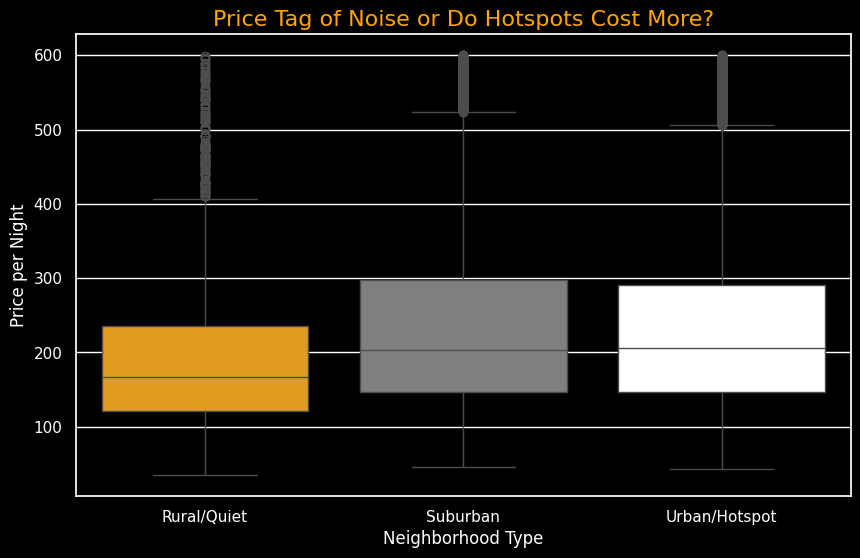

In [59]:
def categorize_density(n):
    if n < 10: return 'Rural/Quiet'
    elif n < 50: return 'Suburban'
    else: return 'Urban/Hotspot'

df['Location_Type'] = df['Density_500m'].apply(categorize_density)


subset = df[df['realSum'] < 600] 

plt.figure(figsize=(10, 6))

order = ['Rural/Quiet', 'Suburban', 'Urban/Hotspot']

sns.boxplot(x='Location_Type', y='realSum', data=subset, order=order, palette=[ORANGE, 'grey', 'white'])

plt.title('Price Tag of Noise or Do Hotspots Cost More?', color=ORANGE, fontsize=16)
plt.ylabel('Price per Night', color='white')
plt.xlabel('Neighborhood Type', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

plt.show()

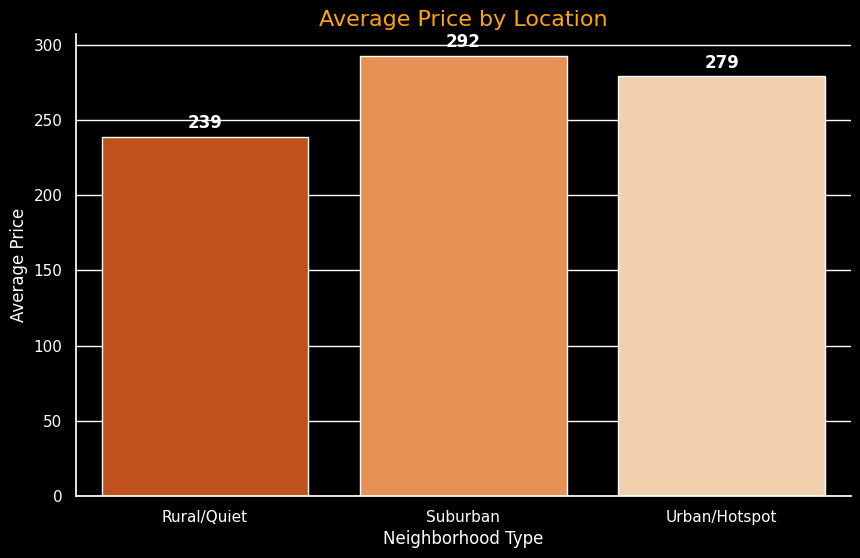

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Location_Type', 
    y='realSum', 
    data=df,
    order=order, 
    palette='Oranges_r', 
    errorbar=None
)

plt.title('Average Price by Location', color=ORANGE, fontsize=16)
plt.ylabel('Average Price', color='white')
plt.xlabel('Neighborhood Type', color='white')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 10), 
                       textcoords='offset points', color='white', fontweight='bold')

plt.xticks(color='white')
plt.yticks(color='white')
sns.despine() 

plt.show()

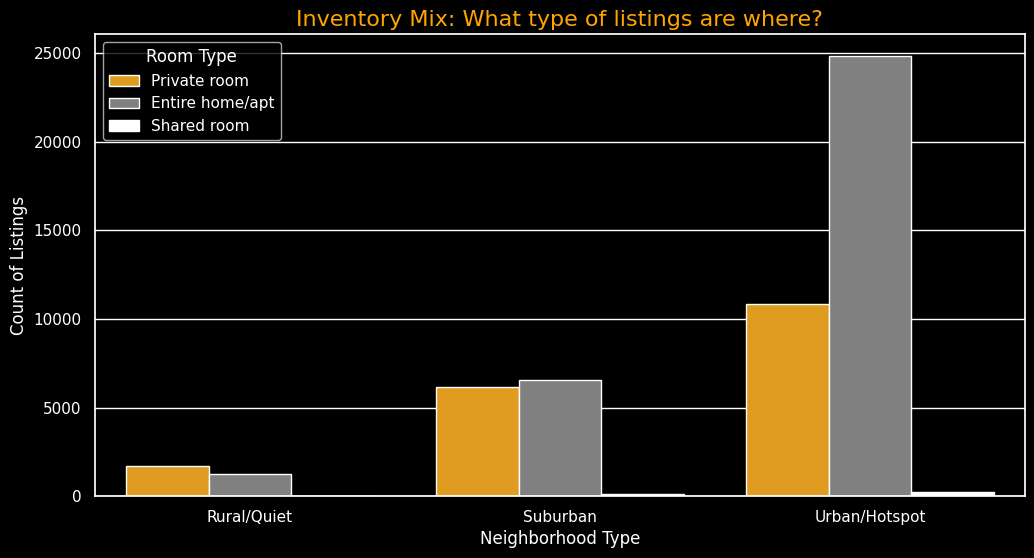

In [61]:
plt.figure(figsize=(12, 6))

sns.countplot(x='Location_Type', hue='room_type', data=df, order=order, palette=[ORANGE, 'grey', 'white'])

plt.title('Inventory Mix: What type of listings are where?', color=ORANGE, fontsize=16)
plt.ylabel('Count of Listings', color='white')
plt.xlabel('Neighborhood Type', color='white')
plt.legend(title='Room Type', facecolor='black', labelcolor='white')
plt.xticks(color='white')
plt.yticks(color='white')

plt.show()

### Stackholders Question?

### Investors

Should I rent my spare room or buy a whole apartment? How much more can I earn?

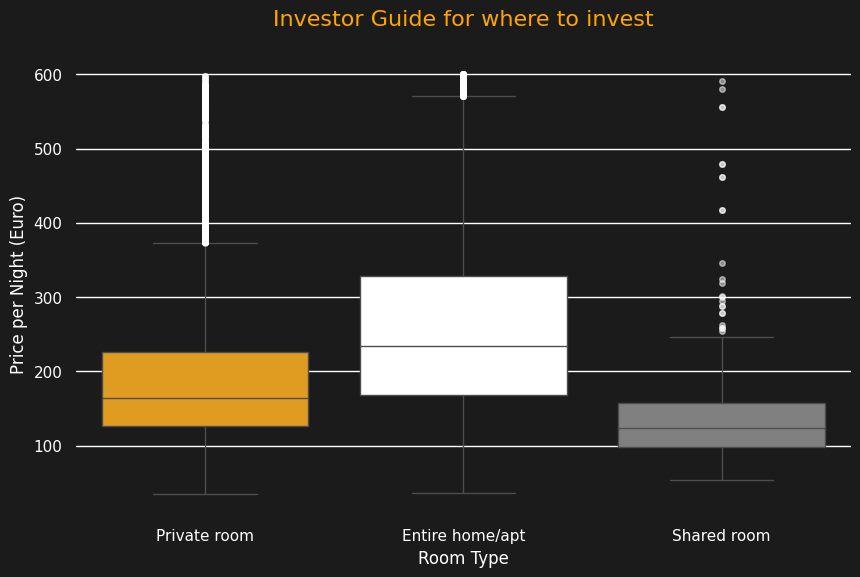

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Set dark background for the figure
plt.gcf().set_facecolor('#1B1B1B')

# Filter for better visualization
subset = df[df['realSum'] < 600]

# Boxplot with custom Outlier styling (flierprops)
sns.boxplot(
    x='room_type', 
    y='realSum', 
    data=subset, 
    palette=[ORANGE, "white", "grey"],
    flierprops={
        'marker': 'o', 
        'markerfacecolor': 'white', # White outliers
        'markeredgecolor': 'white', 
        'markersize': 4,            # Smaller size for cleaner look
        'alpha': 0.5                # Slightly transparent
    }
)

# Styling
plt.title('Investor Guide for where to invest', color=ORANGE, fontsize=16, pad=20)
plt.ylabel('Price per Night (Euro)', color='white')
plt.xlabel('Room Type', color='white')

# Fixing axis colors for dark mode
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#1B1B1B')

# Cleaning up borders
sns.despine(left=True, bottom=True)

plt.show()

Is the price premium for 'Prime Locations' justified? Or does the 'Walkable' zone offer better value for money?

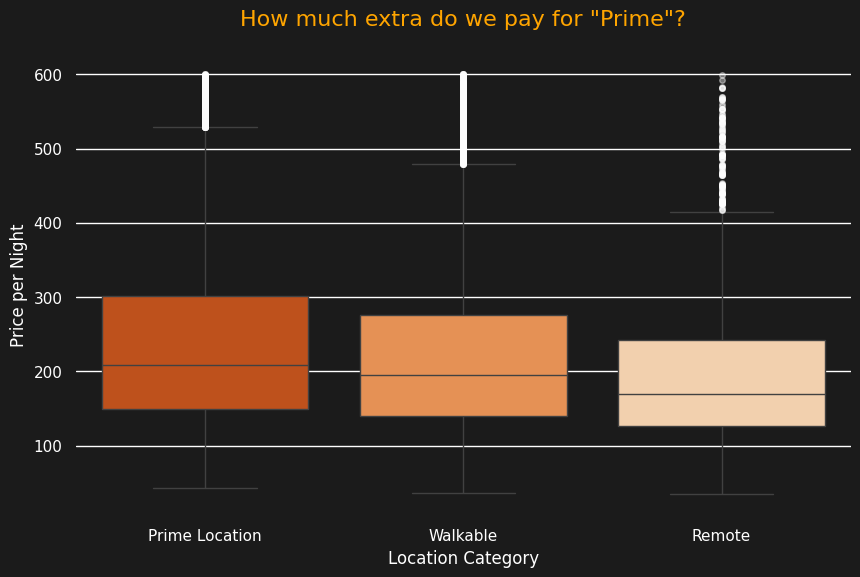

In [63]:
plt.figure(figsize=(10, 6))

plt.gcf().set_facecolor('#1B1B1B')


order = ['Prime Location', 'Walkable', 'Remote']

sns.boxplot(
    x='Distance_Score', 
    y='realSum', 
    data=df[df['realSum'] < 600], 
    order=order, 
    palette='Oranges_r',
    flierprops={
        'marker': 'o', 
        'markerfacecolor': 'white',
        'markeredgecolor': 'white', 
        'markersize': 4, 
        'alpha': 0.4
    }
)

plt.title('How much extra do we pay for "Prime"?', color=ORANGE, fontsize=16, pad=20)
plt.ylabel('Price per Night', color='white')
plt.xlabel('Location Category', color='white')

plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#1B1B1B')

sns.despine(left=True, bottom=True)

plt.show()

#### Guest

If I pay more, will I actually be happier? Or am I just paying for a fancy location?

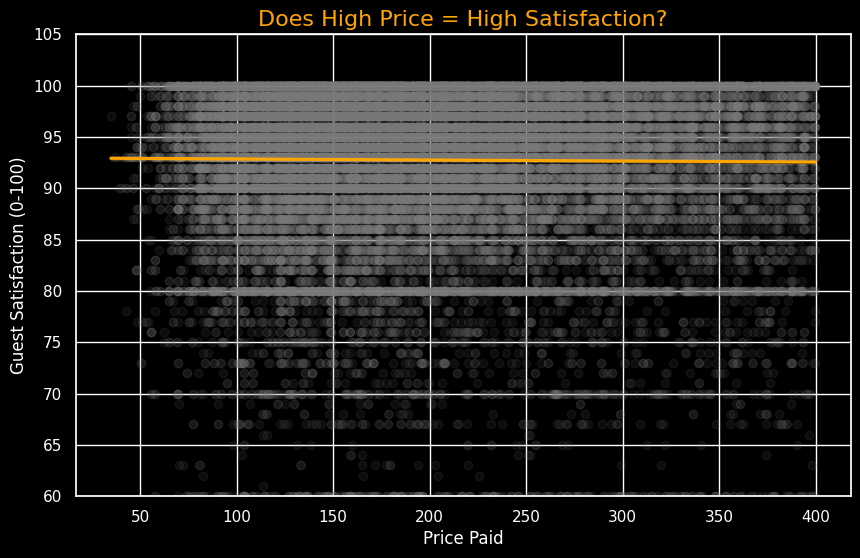

In [64]:
plt.figure(figsize=(10, 6))

# Focus on standard bookings (<400 Euro)
guest_data = df[df['realSum'] < 400]

# Scatter plot with regression line
sns.regplot(x='realSum', y='guest_satisfaction_overall', data=guest_data,
            scatter_kws={'alpha':0.1, 'color': 'grey'},
            line_kws={'color': ORANGE})

plt.title('Does High Price = High Satisfaction?', color=ORANGE, fontsize=16)
plt.xlabel('Price Paid', color='white')
plt.ylabel('Guest Satisfaction (0-100)', color='white')
plt.ylim(60, 105) # Zoom in on the ratings
plt.show()

Is it more economical to travel in a group?
ow drastically does the Price_per_person drop as we add more people?

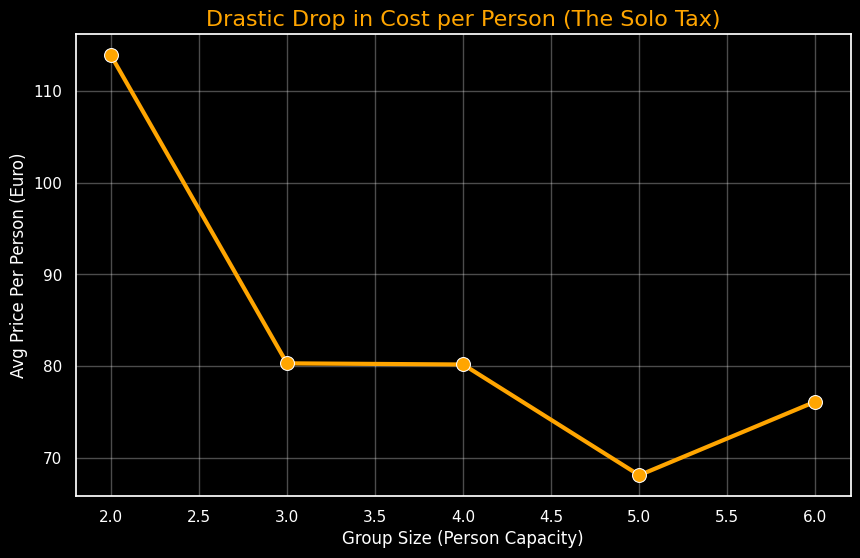

In [65]:
plt.figure(figsize=(10, 6))

capacity_price = df.groupby('person_capacity')['Price_per_person'].mean().reset_index()

sns.lineplot(x='person_capacity', y='Price_per_person', data=capacity_price, 
             color=ORANGE, linewidth=3, marker='o', markersize=10)

plt.title('Drastic Drop in Cost per Person (The Solo Tax)', color=ORANGE, fontsize=16)
plt.ylabel('Avg Price Per Person (Euro)', color='white')
plt.xlabel('Group Size (Person Capacity)', color='white')
plt.grid(True, alpha=0.3)
plt.show()

# capacity_stats = df.groupby('person_capacity')['Price_per_person'].mean()

drop_percentage = capacity_stats.pct_change() * 100

results = pd.DataFrame({
    'Avg Price Per Person': capacity_stats,
    'Drop Percentage': drop_percentage
})

print(results.head(6))

### Group Size Economics: The "Sweet Spot" Analysis

| Person Capacity | Avg Price Per Person | % Change (vs Previous) | Business Insight (Interpretation) |
| :---: | :---: | :---: | :--- |
| **2** | 113.8 | `NaN` | **Baseline:** This is the starting benchmark for couples/pairs. |
| **3** | 80.3 | <span style="color:green">**-29.4%**</span> | **Massive Discount:** The biggest saving tier. Traveling as a trio saves ~30% per person compared to a duo. |
| **4** | 80.2 | <span style="color:gray">-0.15%</span> | **The Plateau:** Virtually no difference. This suggests 3-person and 4-person listings are often the same property size. |
| **5** | 68.1 | <span style="color:green">**-15.0%**</span> | **Value Sweet Spot:** The lowest cost per head. Likely involves using sofa beds/convertibles to maximize capacity. |
| **6** | 76.1 | <span style="color:red">**+11.7%**</span> | **The Luxury Tax:** The trend reverses! Costs *increase* per person. Implies a shift to premium "Entire Homes" in expensive cities (London/Rome). |

In [66]:
group_5 = df[df['person_capacity'] == 5]
group_6 = df[df['person_capacity'] == 6]

print("--- Comparing the prices ---")
print(f"Avg Price (Total) for 5: {group_5['realSum'].mean():.2f}")
print(f"Avg Price (Total) for 6: {group_6['realSum'].mean():.2f}")

print("\n--- The rel with Room Type ---")
print("Dusribution for rooms 5 persons :")
print(group_5['room_type'].value_counts(normalize=True) * 100)
print("-" * 20)
print("Dusribution for rooms for 6 persons:")
print(group_6['room_type'].value_counts(normalize=True) * 100)

print("\n--- Trying to understand if they concentarted in High price cities?---")
print(group_6['City'].value_counts().head(3))

--- Comparing the prices ---
Avg Price (Total) for 5: 340.79
Avg Price (Total) for 6: 457.02

--- The rel with Room Type ---
Dusribution for rooms 5 persons :
room_type
Entire home/apt    93.526405
Private room        6.064736
Shared room         0.408859
Name: proportion, dtype: float64
--------------------
Dusribution for rooms for 6 persons:
room_type
Entire home/apt    95.133365
Private room        2.667291
Shared room         2.199345
Name: proportion, dtype: float64

--- Trying to understand if they concentarted in High price cities?---
City
rome      831
london    682
athens    640
Name: count, dtype: int64


Which cities offer the highest satisfaction per Euro spent?

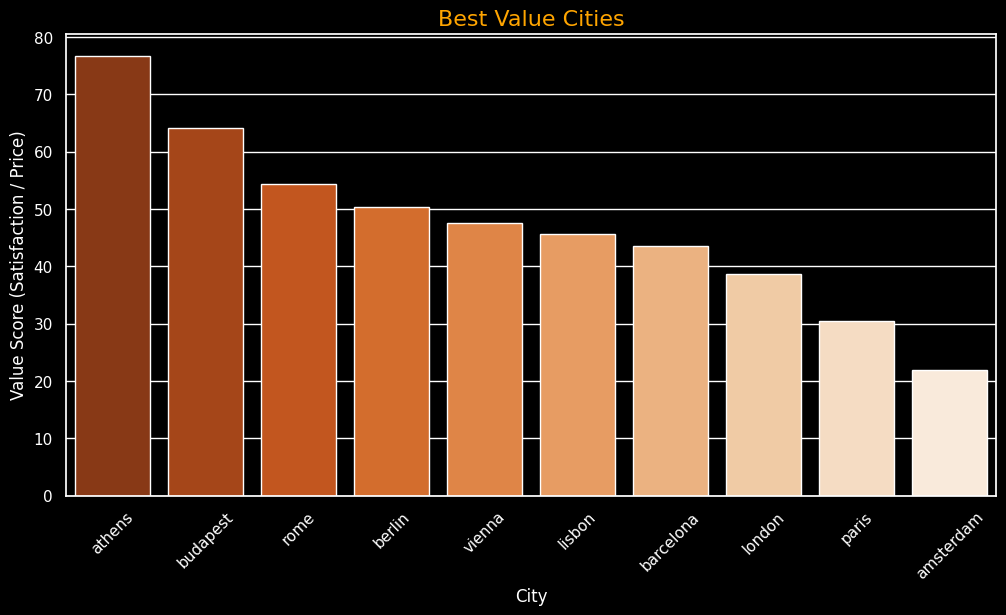

In [67]:
df['Value_Score'] = (df['guest_satisfaction_overall'] * 100) / (df['realSum'] + 1)

plt.figure(figsize=(12, 6))

value_ranking = df.groupby('City')['Value_Score'].mean().sort_values(ascending=False).reset_index()

sns.barplot(x='City', y='Value_Score', data=value_ranking, palette='Oranges_r')

plt.title('Best Value Cities', color=ORANGE, fontsize=16)
plt.ylabel('Value Score (Satisfaction / Price)', color='white')
plt.xlabel('City', color='white')
plt.xticks(rotation=45, color='white')
plt.show()

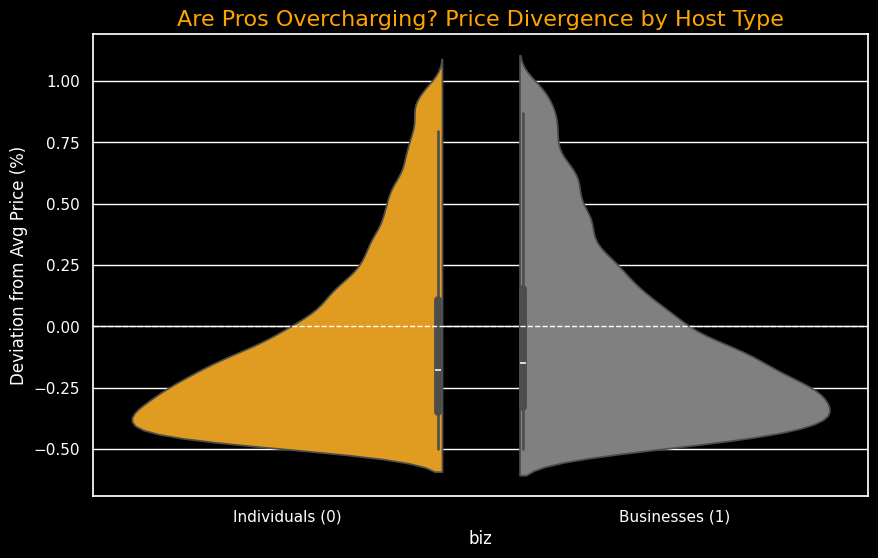

In [68]:
avg_price_by_type = df.groupby('room_type')['realSum'].transform('mean')

plt.figure(figsize=(10, 6))

subset = df[(df['Price_Divergence_Pct'] > -0.5) & (df['Price_Divergence_Pct'] < 1.0)]

sns.violinplot(x='biz', y='Price_Divergence_Pct', data=subset, palette=[ORANGE, 'grey'], split=True)

plt.axhline(0, color='white', linestyle='--', linewidth=1)
plt.title('Are Pros Overcharging? Price Divergence by Host Type', color=ORANGE, fontsize=16)
plt.ylabel('Deviation from Avg Price (%)', color='white')
plt.xticks([0, 1], ['Individuals (0)', 'Businesses (1)'], color='white')
plt.show()

#### Airbnb

Which cities are oversaturated with 'Shared Rooms' and where do we need more 'Entire Homes'?

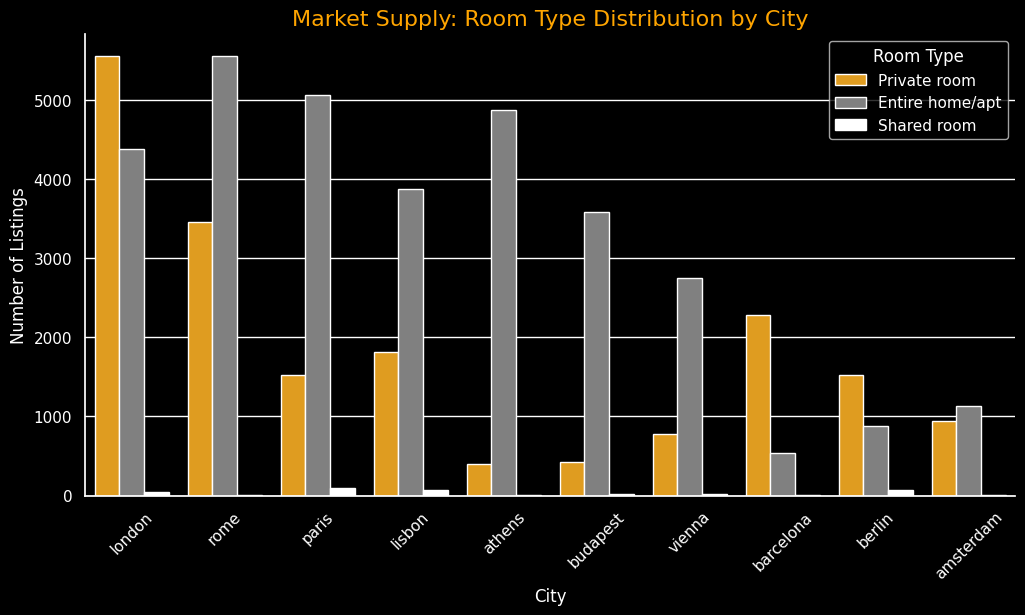

In [69]:
plt.figure(figsize=(12, 6))

# Sort cities by total listings to keep it organized
order = df['City'].value_counts().index

sns.countplot(x='City', hue='room_type', data=df, order=order, palette=[ORANGE, 'grey', 'white'])

plt.title('Market Supply: Room Type Distribution by City', color=ORANGE, fontsize=16)
plt.xlabel('City', color='white')
plt.ylabel('Number of Listings', color='white')
plt.legend(title='Room Type')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
sns.despine()

plt.show()

<Figure size 1200x700 with 0 Axes>

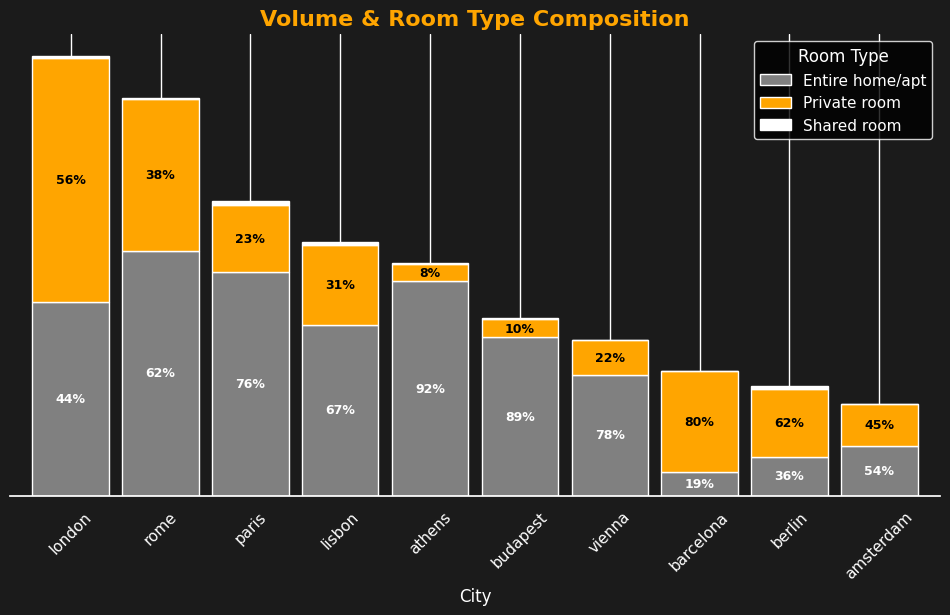

In [70]:
city_room_counts = pd.crosstab(df['City'], df['room_type'])


totals_sorter = city_room_counts.sum(axis=1)

city_room_counts = city_room_counts.loc[totals_sorter.sort_values(ascending=False).index]

totals = city_room_counts.sum(axis=1)

plt.figure(figsize=(12, 7))
colors = ['grey', ORANGE, 'white'] 
ax = city_room_counts.plot(kind='bar', stacked=True, color=colors, figsize=(12,6), width=0.85)

for i, container in enumerate(ax.containers):
    text_color = 'white' if i == 0 else 'black' # Grey bar gets white text
    
    labels = []
    for j, rect in enumerate(container):
        # Fix: Use the total from the SAME index (j) as the bar
        current_total = totals.iloc[j] 
        
        if current_total > 0:
            percentage = (rect.get_height() / current_total) * 100
        else:
            percentage = 0
            
        if percentage > 5: 
            labels.append(f'{percentage:.0f}%')
        else:
            labels.append('')
            
    ax.bar_label(container, labels=labels, label_type='center', color=text_color, fontweight='bold', fontsize=9)

# 5. Styling
plt.title('Volume & Room Type Composition', color=ORANGE, fontsize=16, fontweight='bold')
plt.xlabel('City', color='white')
plt.ylabel('') 
ax.yaxis.set_visible(False)
sns.despine(left=True, bottom=False)
plt.xticks(rotation=45, color='white')

legend = plt.legend(title='Room Type', frameon=True, facecolor='black', edgecolor='white', loc='upper right')
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color("white")

ax.set_facecolor('#1B1B1B')
plt.gcf().set_facecolor('#1B1B1B')

plt.show()

Which listings have high Guest Satisfaction despite average Cleanliness?

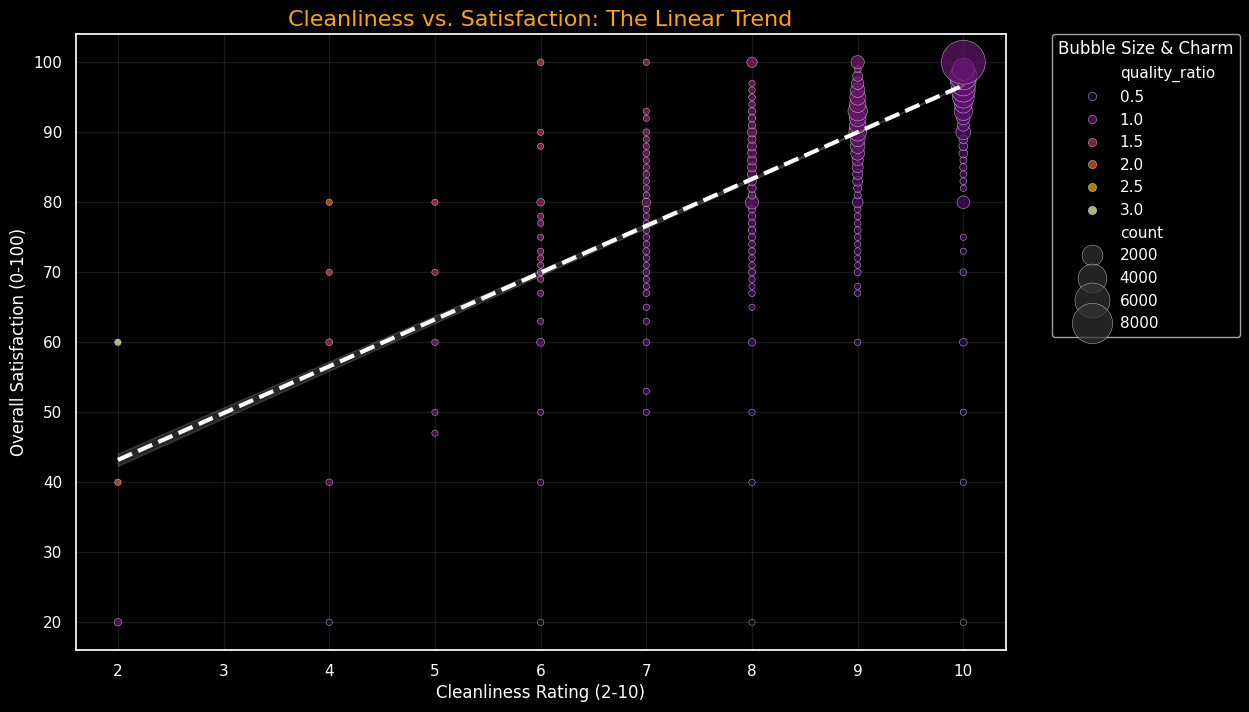

In [71]:
plt.figure(figsize=(12, 8))

bubble_data = df.groupby(['cleanliness_rating', 'guest_satisfaction_overall']).agg(
    count=('realSum', 'count'),
    quality_ratio=('Quality_Ratio', 'mean')
).reset_index()
bubble_data = bubble_data[bubble_data['count'] > 5]

sns.scatterplot(
    data=bubble_data, 
    x='cleanliness_rating', 
    y='guest_satisfaction_overall', 
    size='count', 
    hue='quality_ratio',
    sizes=(20, 1000), 
    palette='inferno', 
    alpha=0.7,
    edgecolor='white',
    legend='brief' 
)


sns.regplot(
    data=df, 
    x='cleanliness_rating', 
    y='guest_satisfaction_overall',
    scatter=False,      
    color='white',      
    line_kws={'linewidth': 3, 'linestyle': '--'}
)

plt.title('Cleanliness vs. Satisfaction: The Linear Trend', color=ORANGE, fontsize=16)
plt.xlabel('Cleanliness Rating (2-10)', color='white')
plt.ylabel('Overall Satisfaction (0-100)', color='white')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Bubble Size & Charm', facecolor='black', labelcolor='white')

plt.grid(True, alpha=0.1)
plt.show()

In [72]:
df.to_csv('airbnb_fe.csv', index=False)

print("File saved successfully in the output directory!")

File saved successfully in the output directory!
